Integrantes do grupo:
 - Caio Alves Caldeira
 - Flavio Lucio Correa Junior
 - Marcos Vinicius Moreira Santos
 - Vinicius Julião Ramos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit

## Funções para o cáculo do modelo de Isigin 2d através do algoritmo de Metrópolis

In [2]:
@jit(nopython=True)
def expos(beta): 
    ex = np.zeros(5,dtype=np.float32) 
    ex[0]=np.exp(8.0*beta) 
    ex[1]=np.exp(4.0*beta) 
    ex[2]=0.0 
    ex[3]=np.exp(-4.0*beta) 
    ex[4]=np.exp(-8.0*beta) 
    return ex

In [3]:
@jit(nopython=True)
def mcstep(beta,s,viz,ener,mag):
    N=len(s)
    ex=expos(beta)
    for i in range(N):
        h = s[viz[i,0]]+s[viz[i,1]]+s[viz[i,2]]+s[viz[i,3]]
        de = int(s[i]*h*0.5+2)
        if np.random.random() < ex[de]:
            ener=ener+2*s[i]*h
            mag -= 2*s[i]
            s[i]=-s[i]
    return ener,mag,s

In [4]:
def genviz(s, L, N):
    iviz1 = lambda i: [
        i+1-L if i % L == 0 else i+1,
        i+L-N if i > N-L else i+L,
        i+L-1 if (i-1) % L == 0 else i-1,
        i+N-L if i < L+1 else i-L
    ]
    iviz = lambda i: [j-1 for j in iviz1(i)]
    return np.array([iviz(i+1) for i in range(N)])


In [5]:
def initcfg(s, L, N, T):
    beta = 1/T
    viz = genviz(s, L, N)
    mag = np.sum(s) / N
    ener = -np.sum([s[i] * (s[viz[i,0]] + s[viz[i,1]]) for i in range(N)])
    return s,viz,ener,mag

In [6]:
@jit(nopython=True)
def s_ini(N):
    #Gera um estadon inicial aleatório para rede
    s = np.zeros(N,dtype=np.int64)
    for i in range(N):
        s[i] = np.sign(2*np.random.random()-1)
    return s

def randcfg(L, N, T):
    s = s_ini(N)
    return initcfg(s, L, N, T)

### Obtenção dos dados das caixas antes do cálculo dos erros e médias

In [7]:
def run(L, T, s, viz, ener, mag):
    beta = 1/T
    N = L**2
    
    box_size = int(1e5)
    boxes = {}
    boxes["ener"] = [] # Energia Média
    boxes["ener2"] = [] # Energia Media^2
    boxes["mag"] = [] # Magnetização Média
    boxes["mag2"] = [] # Magnetização Média^2

    
    for i in range(int(1e5)):
        ener, mag, s = mcstep(beta, s, viz, ener, mag)

    cumEner,cumEner2,cumMag,cumMag2 = 0, 0, 0, 0
    count = 1
    for i in range(int(1e6)):
        ener, mag, s = mcstep(beta, s, viz, ener, mag)
        cumEner += ener
        cumEner2 += ener**2
        cumMag += abs(mag)
        cumMag2 += mag**2
        count += 1
        
        if(count == box_size):
            boxes["ener"].append(cumEner/box_size)
            boxes["ener2"].append(cumEner2/box_size)
            boxes["mag"].append(cumMag/box_size)
            boxes["mag2"].append(cumMag2/box_size)
            cumEner,cumEner2,cumMag,cumMag2 = 0, 0, 0, 0
            count = 1

    return boxes, s, viz, ener, mag

In [8]:
temperaturas = [5., 4.75, 4.5, 4.25, 4., 3.75, 3.5, 3.25, 3., 2.75, 2.5, 2.25, 2., 1.75, 1.5, 1.25, 1.]
tamanhos = [18, 24, 36]

In [9]:
# Rodando quando L = 18
L = tamanhos[0]
s, viz, ener, mag = randcfg(L, L**2, temperaturas[0])
boxes_per_temperature_l18 = {}
for T in temperaturas:
    boxes, s, viz, ener, mag  = run(L, T, s, viz, ener, mag)
    boxes_per_temperature_l18[T] = boxes

In [10]:
# Rodando quando L = 24
L = tamanhos[1]
s, viz, ener, mag = randcfg(L, L**2, temperaturas[0])
boxes_per_temperature_l24 = {}
for T in temperaturas:
    boxes, s, viz, ener, mag  = run(L, T, s, viz, ener, mag)
    boxes_per_temperature_l24[T] = boxes

In [11]:
# Rodando quando L = 36
L = tamanhos[2]
s, viz, ener, mag = randcfg(L, L**2, temperaturas[0])
boxes_per_temperature_l36 = {}
for T in temperaturas:
    boxes, s, viz, ener, mag  = run(L, T, s, viz, ener, mag)
    boxes_per_temperature_l36[T] = boxes

### Cálculo e exibição das médias e erros

In [12]:
def error(data):
    erro = 0
    size = len(data)
    
    for i in range(size):
        erro += (data[i] - np.mean(data))**2
    return np.sqrt(erro/(size*(size-1)))

def show(medias, erros, title):
    plt.rcParams["figure.figsize"] = (20, 5)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'{title}: valores médios por temperatura e erros estatísticos')

    for i in range(len(tamanhos)):
        ax1.plot(temperaturas[::-1], medias[i], label=f'Rede L={tamanhos[i]}')
        ax2.plot(temperaturas[::-1], erros[i], label=f'Rede L={tamanhos[i]}')

    ax1.set_title(title)
    ax1.set(ylabel=title)
    ax1.set(xlabel='Temperatura')

    ax2.set_title('Erro estatístico')
    ax2.set(ylabel='Erro estatístico')
    ax2.set(xlabel='Temperatura')

    plt.legend()
    plt.show()    

### Gráficos da energia por spin e magnetização por spin


In [13]:
print(tamanhos)

[18, 24, 36]


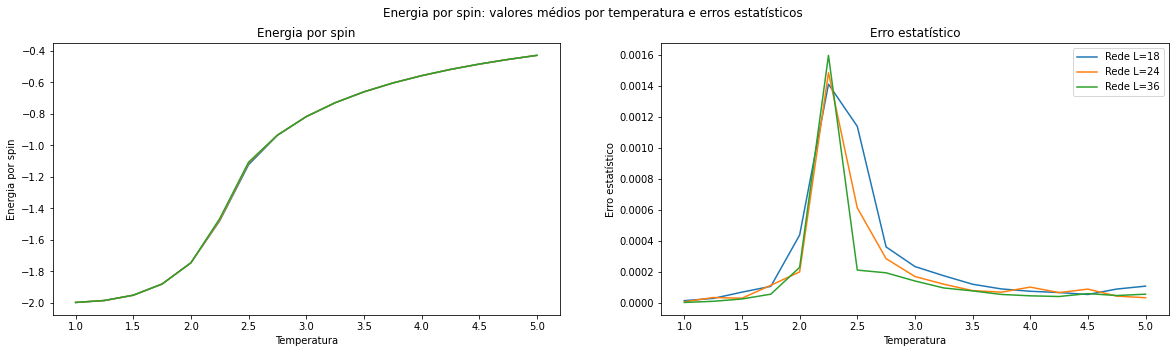

In [14]:
def erro_e_media_por_spin(results, data_name):
    medias = []
    erros = []
    i = 0
    for result in results:
        cumMean = []
        cumError = []
        N = tamanhos[i]**2
        i+=1
        for T in temperaturas[::-1]:
            energia = np.array(result[T][data_name])
            energia /= N

            mean_data_per_spin = np.mean(energia)
            erro = error(energia)

            cumMean.append(mean_data_per_spin)
            cumError.append(erro)

        medias.append(cumMean)
        erros.append(cumError)
    return medias, erros


results = [boxes_per_temperature_l18,
           boxes_per_temperature_l24,
           boxes_per_temperature_l36]

media, erro = erro_e_media_por_spin(results, 'ener')
show(media, erro, title='Energia por spin')

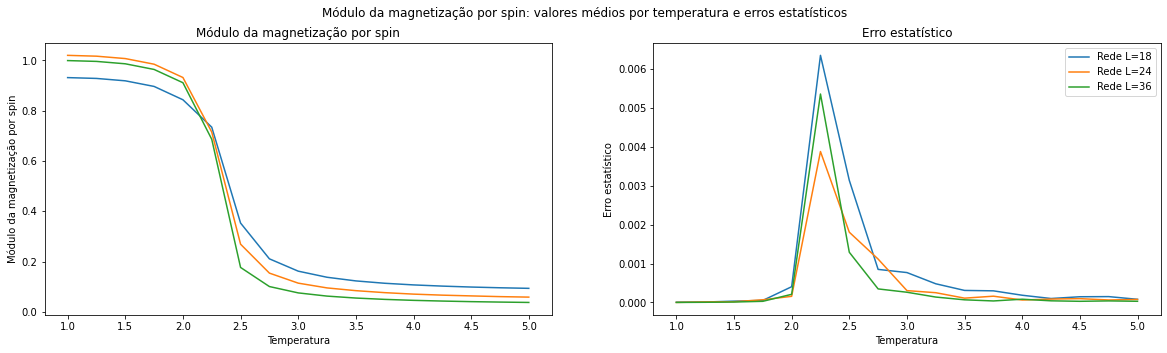

In [15]:
media, erro = erro_e_media_por_spin(results, 'mag')
show(media, erro, title='Módulo da magnetização por spin')

### Gráficos do calor específico

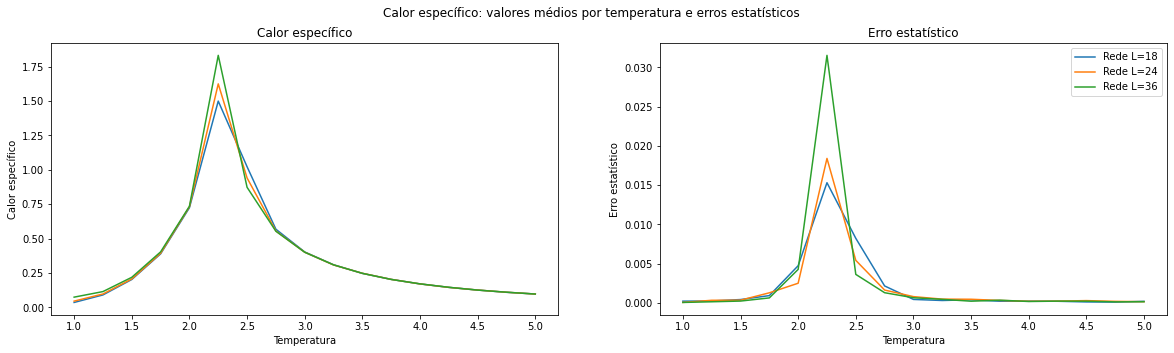

In [16]:
def medias_erros_do_calor_especifico(results):
    medias = []
    erros = []
    j = 0

    for result in results:
        cumMean = []
        cumError = []
        N = tamanhos[j]**2
        j+=1
        
        for T in temperaturas[::-1]:    
            beta = 1/T
            energia = np.array(result[T]["ener"])
            energia2 = np.array(result[T]["ener2"])
            
            cv = []
            fator = (beta**2)/N
            for i in range(len(energia)):
                cv.append((fator * (energia2[i] - energia[i]**2)))

            calor_especifico = np.mean(cv)
            erro = error(cv)

            cumMean.append(calor_especifico)
            cumError.append(erro)

        medias.append(cumMean)
        erros.append(cumError)
    return medias, erros

medias, erros = medias_erros_do_calor_especifico(results)
show(medias, erros, title='Calor específico')

### Gráficos da susceptibilidade magnética

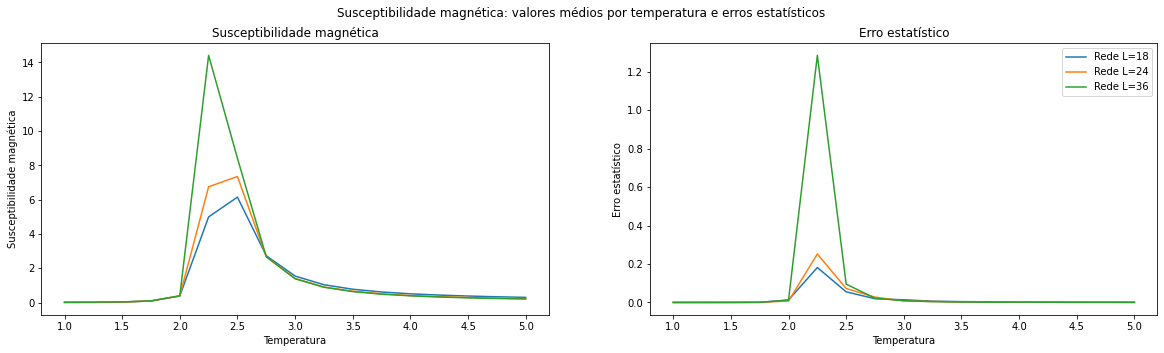

In [17]:
def medias_erros_da_susceptibilidade_magnetica(results):
    medias = []
    erros = []
    j = 0

    for result in results:
        cumMean = []
        cumError = []
        N = tamanhos[j]**2
        j+=1
        for T in temperaturas[::-1]:
            beta = 1/T
            sm = []
            mag = np.array(result[T]["mag"])
            mag2 = np.array(result[T]["mag2"])

            fator = beta/N
            for i in range(len(mag)):
                sm.append((fator * (mag2[i] - mag[i]**2)))

            susceptibilidade_magnetica = np.mean(sm)
            erro = error(sm)

            cumMean.append(susceptibilidade_magnetica)
            cumError.append(erro)

        medias.append(cumMean)
        erros.append(cumError)

    return medias, erros

medias, erros = medias_erros_da_susceptibilidade_magnetica(results)
show(medias, erros, title='Susceptibilidade magnética')

## Relatório

Inicialmente vale a pena ressaltar que dada a baixa magnitude dos erros em comparação aos valores médios, optou-se por não exibir o erro estatístico na forma de barras que acompanhassem as linhas dos gráficos das médias. Como os valores de erro estão em escalas menores do que as médias, a vizualização ficaria prejudicada, uma vez que a exibição no Jupyter Notebook não permite zoom ou interações com o gáfico. Não havendo forma de aplicar *zoom* ou aumentar o tamanho da visualizaçõa dos gráficos, optou-se, então, pela exibição dos gráficos das médias (sempre à esquerda) seguida com o gráfico do respectivo erro estatístico (sempre à direita).

Calcular o comportamento de sistemas com tamanho ($L$) muito grande, é computacionalmente muito custoso. Mesmo para o valor $L=36$ que aplicou-se neste experimento, já houve certa demora na computação. Então, baseando-se no que fora apresentado pelos resultados dos experimentos, para sistemas muito grandes (ou até mesmo de tamanho infinito) pode-se esperar que os valores **Energia por Spin** ($E$) e **Módulo da Magnetização por Spin** ($|M|$) sejam passíveis de predição com boa confiabilidade. Isso se deve, pelo fato de que para valores de $L \in \{18, 24, 36\}$ tanto $E$ quando $|M|$ obtiveram resultados muito próximos, incluindo também o valor dos respectivos erros estatísticos. Além do mais, o valor do erro estatístico de $E$ e $|M|$ não se mostraram dependentes do tamanho do sistema, o que leva a inferir que essas grandezas não são dependentes do tamanho do sistema.

Entretanto, o resultado dos experimentos para **Calor Específico** ($c_v$) e **Susceptibilidade Magnética** ($X$) não condiz com o comportamento da Energia por Spin e do Modulo da Magnetização por Spin, quando os sitema possui tamanho infinito (ou é muito grande). Para os dois ultimos experimentos, o erro estatístico comportou-se de maneira correlacionada ao tamanho ($L$) do sistema. Observando os gráficos de $c_v$ e $X$ observamos que quão maior o valor de $L$, maior foi o erro estatístico do cálculo realizado sob a temperatura crítica. Entretanto, apesar da correlação com o tamanho do sistema, a cauda observada nos gráficos de erro não parece sofrer tanta interferência. O que permitiria afirmar que a dificuldade de previsão do comportamento dessas grandezas (Calor Específico e Susceptibilidade Magnética), para $L$ muito grande (ou infito), só seria dificultada nas proximidades da temperatura crítica. Sendo assim, para $L$ infinito, desde o sistema esteja "distante" da temperatura crítica, o comportamento de $c_v$ e $X$ não é impactado.

É possível notar um indício de transição de fase em todos os gráficos. Este indício consiste no pico que todas as linhas formam em torno da temperatura $T=2.5$. Nos gráficos que não envolvem o erro estatístico, sobre o ponto em que a temperatura $T=2.5$ há um ponto de inflexão em todos as linhas. Além disso, à medida que a temperatura varia em direção ao ponto de inflexão dos gráficos de $c_v, X, E$ e $|M|$, os respectivos erros estatísticos também aumentam. A formação do pico nos gráficos de erro estatístico reinforçãm o indício da mudança de fase, pois corrobora as falas do professor em aula, que avaliou a mudança de fase como "momento" de instabilidade. Em outras palavras, essa instabilidade impacta inclusive o cálculo do valores $c_v, X, E$ e $|M|$, uma vez que é mais dificil precisar os valores, dado o aumento do erro (incerteza) em torno de $T=2.5$.